# Unlocking Church Growth: Data Insights from the National Congregations Study
# Facilities Analysis

## Objective
In this segment of the analysis we specifically explore the features associated to the Facilities of the congregation and how they may impact an attendance change. The features included are:<br>
 - Building: The type of building used for the primary worship services (i.e., School, Storefront, Church/Synagogue/Temple/Mosque, or Other)
 - Artwork: identifies if visitors come to view the architecure, artwork, stained glass, or statues
 - Remodel: was there a remodel in recent years?
 - Founded: year the primary building was founded
 - Home School: are homeschool group(s) sponsored?
 - School: K-12 school onsite
 - Building Use: Other groups, programs or events not connected to the congeregation
 - Permits: permits or licenses are obtained (i.e., Kitchen, Remodeling, Liquor, Day Care, Bingo/Gambling/Raffle, Statue/Signage, Festival/Bazaar, Zoning, Tax Exemption, etc.)

## Data Preparation

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

In [2]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [3]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

In [4]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

### Data Transformations

In [5]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [6]:
# Select specific features
selected_columns = ['DENOM', 'BLDGTYPE', 'VIEWBLDG', 'REMODEL', 'HOMESCHL', 'HAVESCHL', 'USEBLDG', 'PERMPURP', 'change_category']
df_facilities = data[selected_columns].copy()

In [7]:
# Change column data types for FACILITIES
df_facilities['BLDGTYPE'] = df_facilities['BLDGTYPE'].astype('category')
df_facilities['PERMPURP'] = df_facilities['PERMPURP'].astype('category')

In [8]:
# Drop DENOM
df_facilities.drop(['DENOM'], axis=1, inplace=True)

# One-Hot Encoding
categorical_columns = df_facilities.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_facilities[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
#df_facilities_encoded = pd.concat([df_facilities.reset_index(drop=True), encoded_df], axis=1)
df_facilities_encoded = pd.concat([df_facilities, encoded_df], axis=1)
df_facilities_encoded = df_facilities_encoded.drop(categorical_columns, axis=1)

## Descriptive Analysis

In [9]:
# Basic exploration
df_facilities.info()
df_facilities.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   BLDGTYPE         5327 non-null   category
 1   VIEWBLDG         1228 non-null   object  
 2   REMODEL          1420 non-null   object  
 3   HOMESCHL         1505 non-null   object  
 4   HAVESCHL         5318 non-null   object  
 5   USEBLDG          2293 non-null   object  
 6   PERMPURP         413 non-null    category
 7   change_category  5333 non-null   category
dtypes: category(3), object(5)
memory usage: 225.7+ KB


,BLDGTYPE,VIEWBLDG,REMODEL,HOMESCHL,HAVESCHL,USEBLDG,PERMPURP,change_category
count,5327,1228,1420,1505,5318,2293,413,5333
unique,4,2,2,2,2,2,29,3
top,"Church, Synagogue, Temple, or Mosque",True,False,False,False,True,Buliding/Remodeling,Same
freq,5076,652,955,1295,4304,1573,176,4383


## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

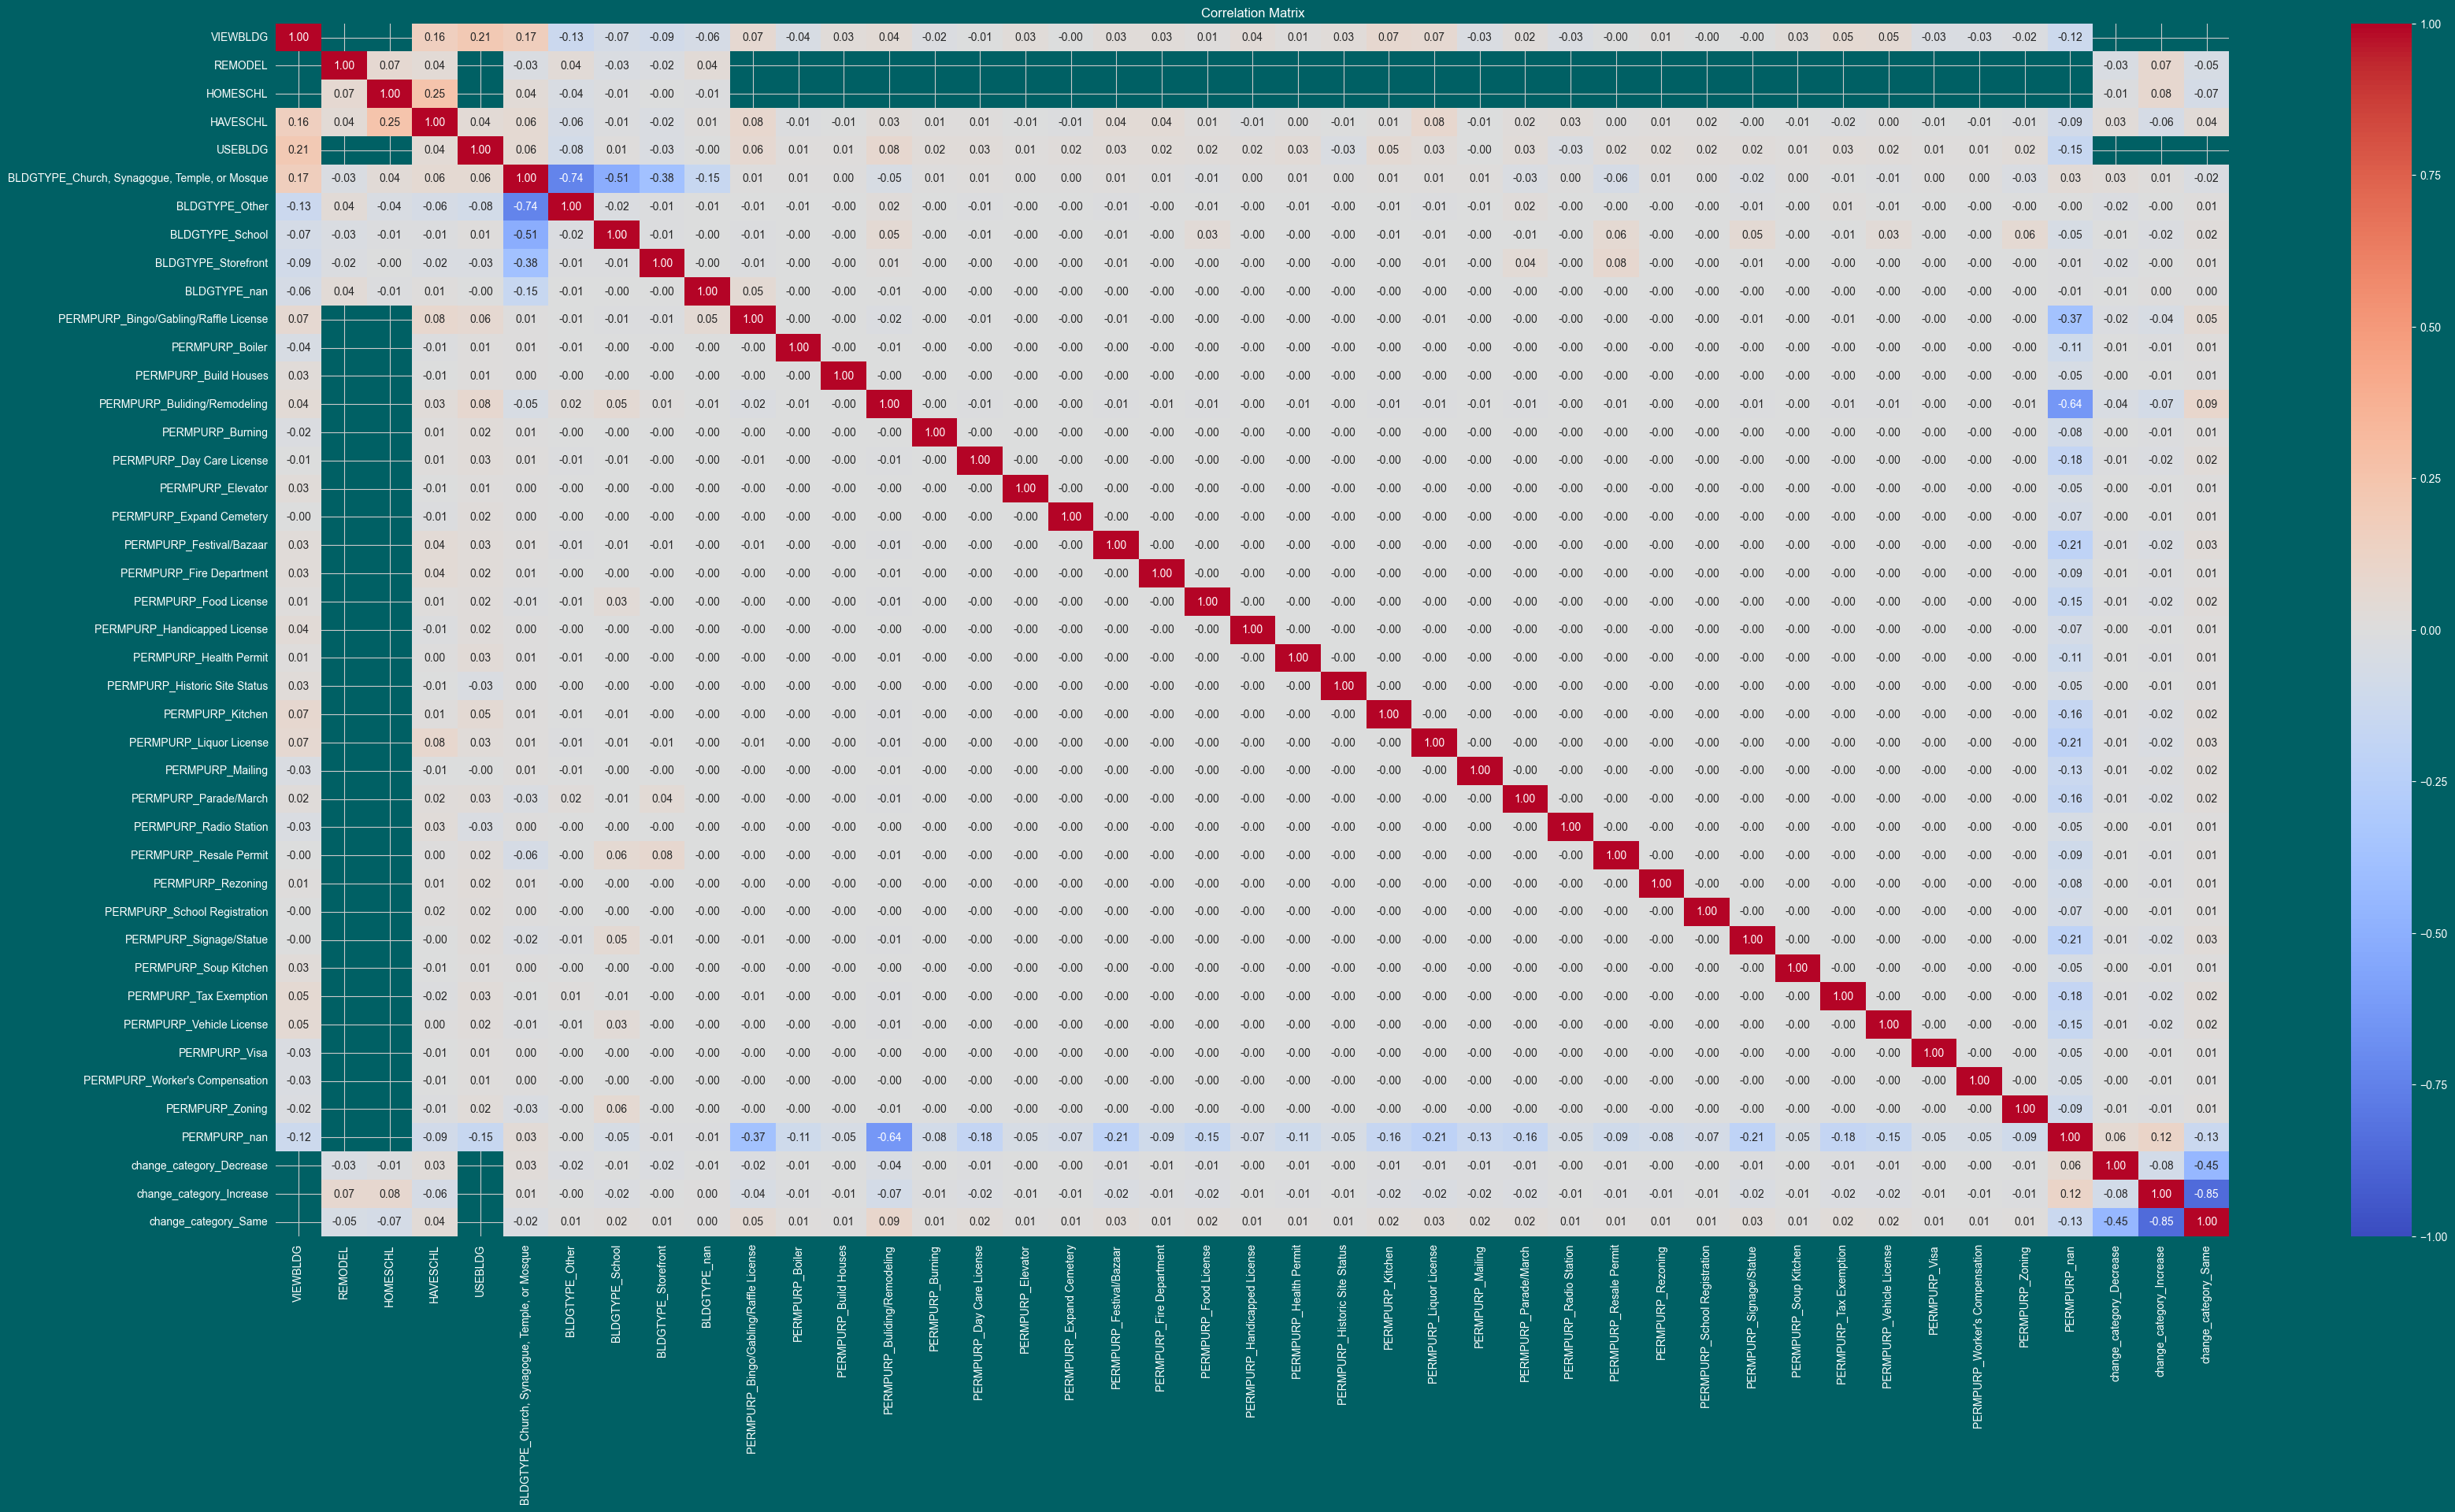

In [10]:
# Perform correlation analysis
correlation_matrix = df_facilities_encoded.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

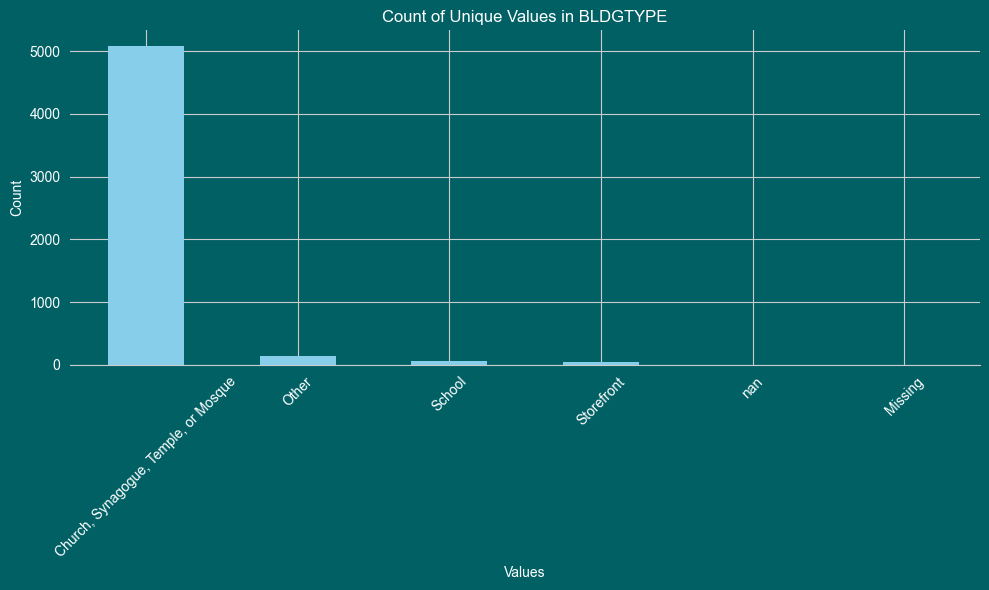

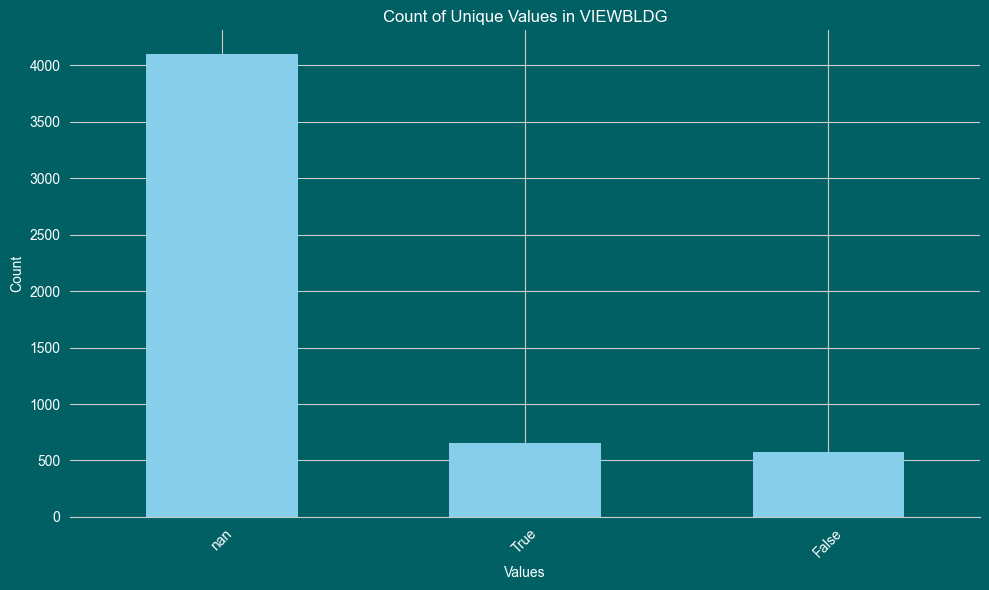

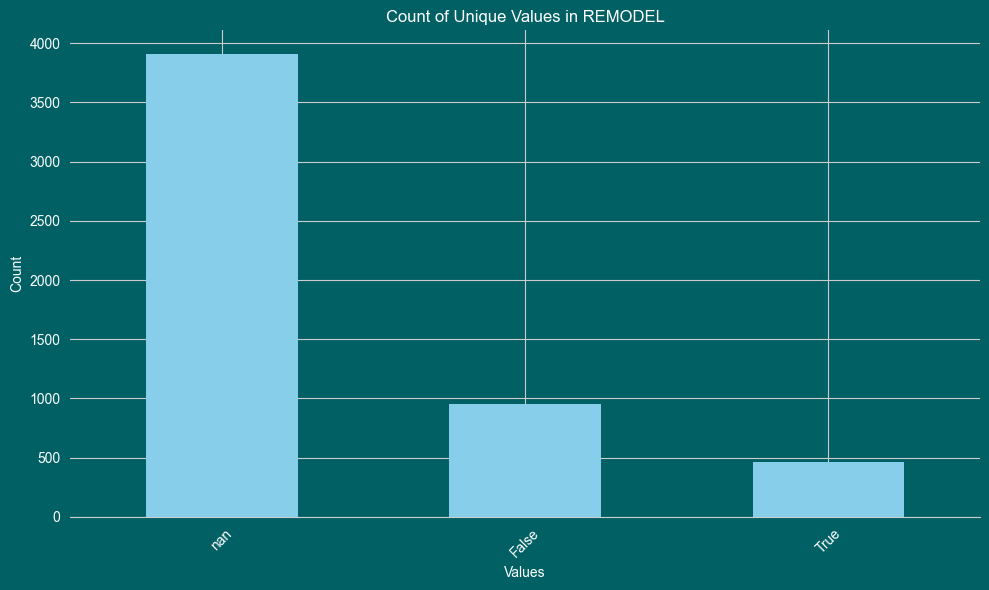

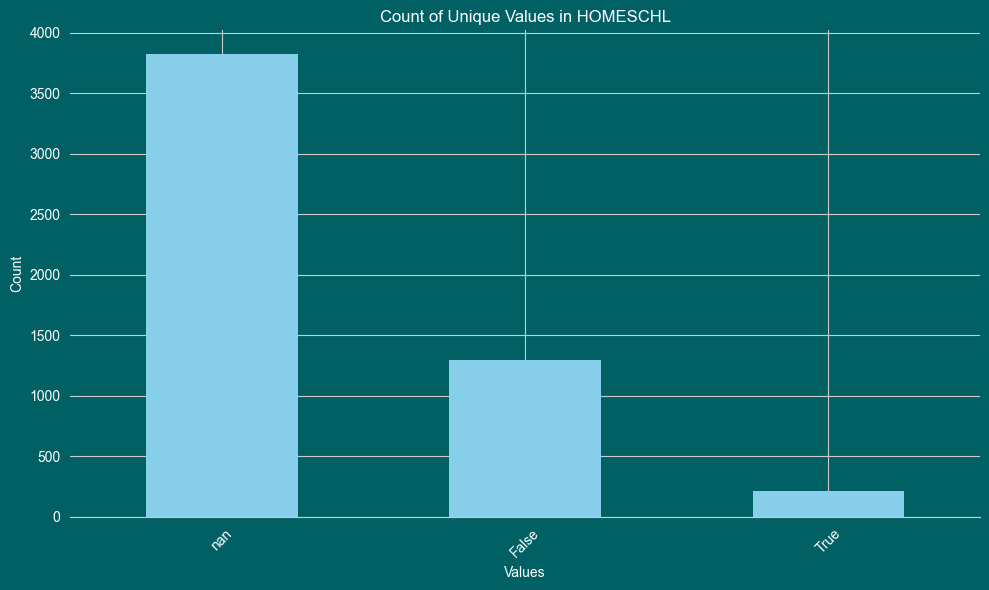

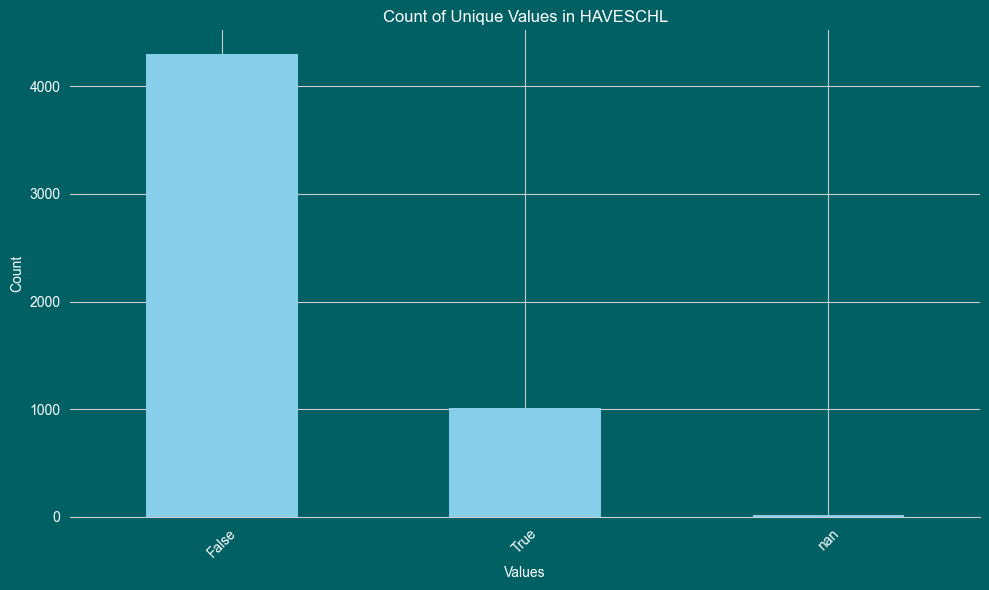

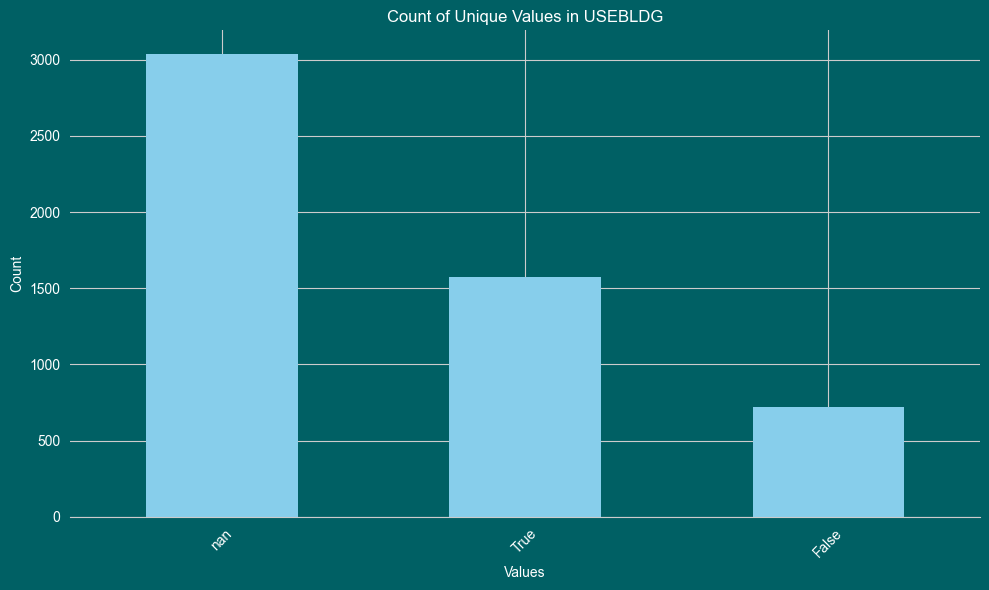

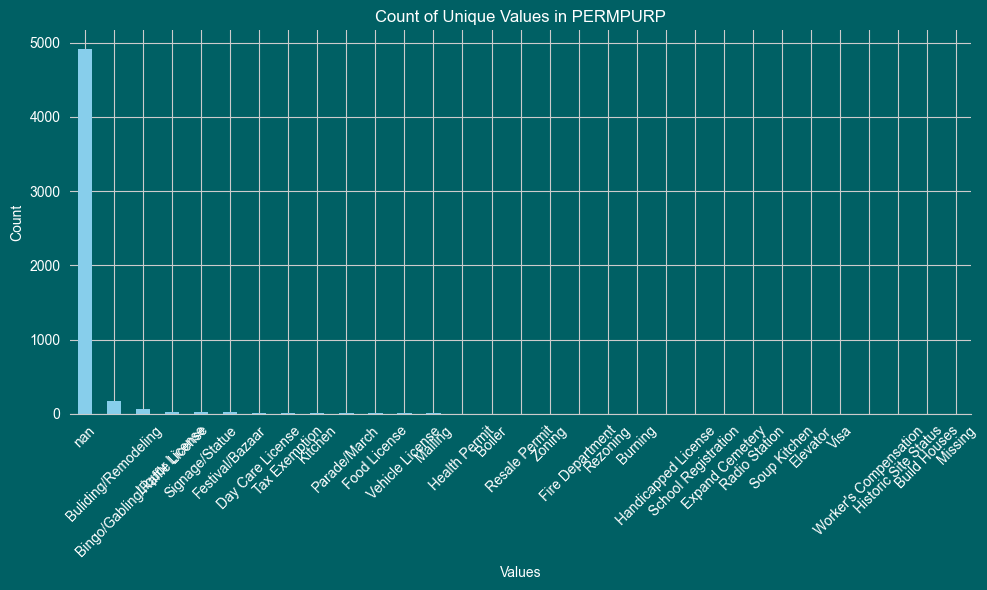

In [17]:
# Specify columns of interest
columns_of_interest = ['BLDGTYPE', 'VIEWBLDG', 'REMODEL', 'HOMESCHL', 'HAVESCHL', 'USEBLDG', 'PERMPURP']

# Count unique values for each column
counts = {col: df_facilities[col].value_counts(dropna=False) for col in columns_of_interest}

# Plot counts for each column
for col, count in counts.items():
    plt.figure(figsize=(10, 6))
    count.plot(kind='bar', color='skyblue')
    
    # Adding labels and title
    plt.xlabel('Values')
    plt.ylabel('Count')
    plt.title(f'Count of Unique Values in {col}')
    
    # Show plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

In [18]:
# Inferential Analysis

# Select specific features and drop rows with missing target data
df_facilities_inferential = data[['BLDGTYPE', 'VIEWBLDG', 'REMODEL', 'HOMESCHL', 'HAVESCHL', 'USEBLDG', 'PERMPURP', 'change_category']]

# Drop rows with missing target data
df_facilities_inferential = df_facilities_inferential.dropna(subset=['change_category'])

# Convert facility type columns to categorical
facilities_types = ['VIEWBLDG', 'REMODEL', 'HOMESCHL', 'HAVESCHL', 'USEBLDG']
for col in facilities_types:
    df_facilities_inferential[col] = df_facilities_inferential[col].astype('category')

# Function to perform Chi-Square test
def perform_chi2_test(df, feature):
    contingency_table = pd.crosstab(df[feature], df['change_category'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    return chi2_stat, p_val

# Perform Chi-Square test for each feature
chi2_results = {feature: perform_chi2_test(df_facilities_inferential, feature) for feature in facilities_types}

# Display Chi-Square results
for feature, (chi2_stat, p_val) in chi2_results.items():
    print(f"Chi-Square test for {feature}: Chi2-statistic = {chi2_stat:.4f}, p-value = {p_val:.4e}")

Chi-Square test for VIEWBLDG: Chi2-statistic = 0.0000, p-value = 1.0000e+00
Chi-Square test for REMODEL: Chi2-statistic = 7.6158, p-value = 2.2195e-02
Chi-Square test for HOMESCHL: Chi2-statistic = 9.2488, p-value = 9.8093e-03
Chi-Square test for HAVESCHL: Chi2-statistic = 18.4428, p-value = 9.8899e-05
Chi-Square test for USEBLDG: Chi2-statistic = 0.0000, p-value = 1.0000e+00


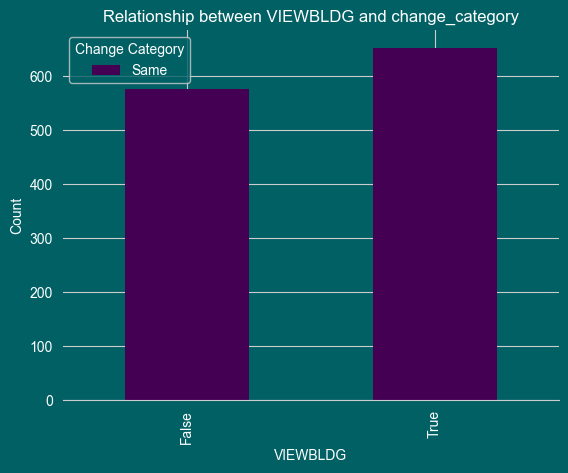

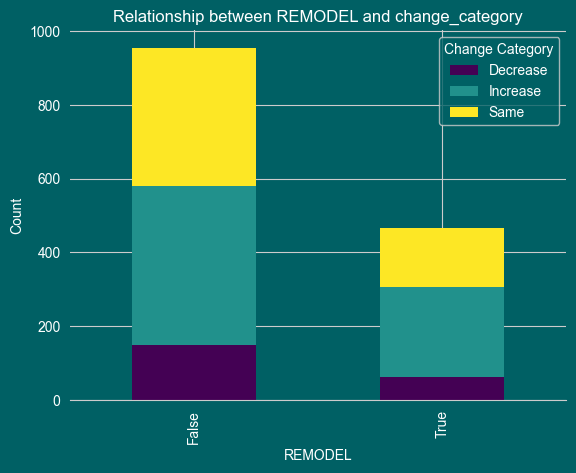

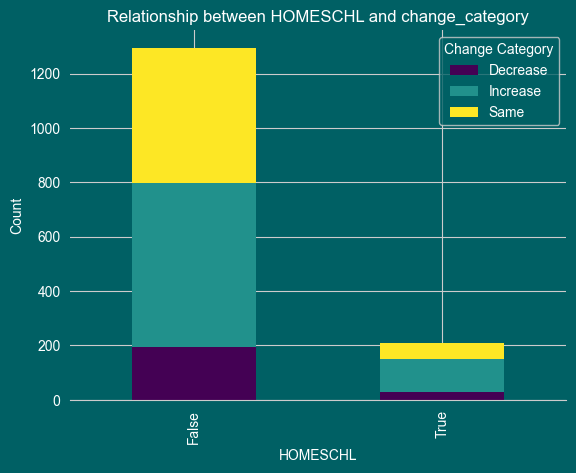

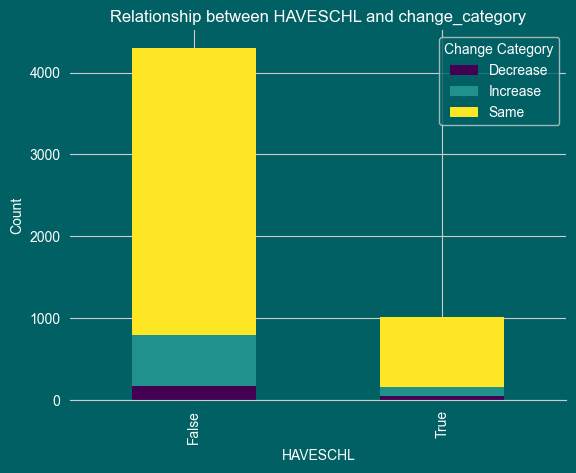

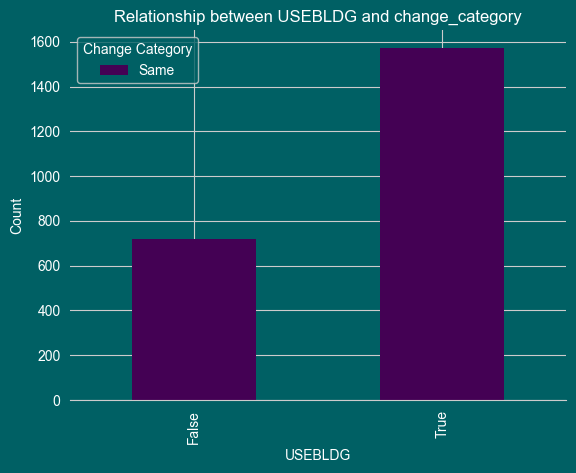

In [19]:
# Function to plot relationship
def plot_relationship(df, feature):
    contingency_table = pd.crosstab(df[feature], df['change_category'])
    contingency_table.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'Relationship between {feature} and change_category')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Change Category')
    plt.show()

# Plot relationships
for feature in facilities_types:
    plot_relationship(df_facilities_inferential, feature)

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

In [20]:
# Determine NaN value counts in each column
nan_counts = df_facilities.isnull().sum()
print("NaN value counts in each column:")
print(nan_counts)

NaN value counts in each column:
BLDGTYPE              6
VIEWBLDG           4105
REMODEL            3913
HOMESCHL           3828
HAVESCHL             15
USEBLDG            3040
PERMPURP           4920
change_category       0
dtype: int64


In [23]:
# Logistic Regression

# Select specific columns and drop NaN values
df_facilities_logit = df_facilities[['REMODEL', 'HOMESCHL', 'HAVESCHL', 'change_category']].dropna()

# One-Hot Encoding for the target variable
df_facilities_logit['change_category'] = df_facilities_logit['change_category'].astype('category')
encoder = OneHotEncoder(sparse_output=False)
encoded_target = encoder.fit_transform(df_facilities_logit[['change_category']])
encoded_target_df = pd.DataFrame(encoded_target, columns=encoder.get_feature_names_out(['change_category']))

# Merge encoded target with the main dataframe and drop the original target column
df_facilities_logit = pd.concat([df_facilities_logit.reset_index(drop=True), encoded_target_df], axis=1)
df_facilities_logit.drop(['change_category'], axis=1, inplace=True)

# Encode the target variable for logistic regression
# Assuming 'change_category_Increase' is the column for the positive class
target = df_facilities_logit['change_category_Increase']
df_facilities_logit.drop(['change_category_Increase', 'change_category_Decrease', 'change_category_Same'], axis=1, inplace=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_facilities_logit, target, test_size=0.3, random_state=42)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature importance
feature_importance = pd.Series(model.coef_[0], index=X_train.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

Accuracy: 0.6197183098591549
Confusion Matrix:
[[182  50]
 [112  82]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.78      0.69       232
         1.0       0.62      0.42      0.50       194

    accuracy                           0.62       426
   macro avg       0.62      0.60      0.60       426
weighted avg       0.62      0.62      0.61       426

Feature Importance:
HOMESCHL    0.429890
REMODEL     0.207805
HAVESCHL   -0.516974
dtype: float64


## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

In [24]:
# Random Forest

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

Accuracy: 0.6173708920187794
Confusion Matrix:
[[189  43]
 [120  74]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.81      0.70       232
         1.0       0.63      0.38      0.48       194

    accuracy                           0.62       426
   macro avg       0.62      0.60      0.59       426
weighted avg       0.62      0.62      0.60       426

Feature Importance:
HAVESCHL    0.484301
REMODEL     0.259583
HOMESCHL    0.256116
dtype: float64


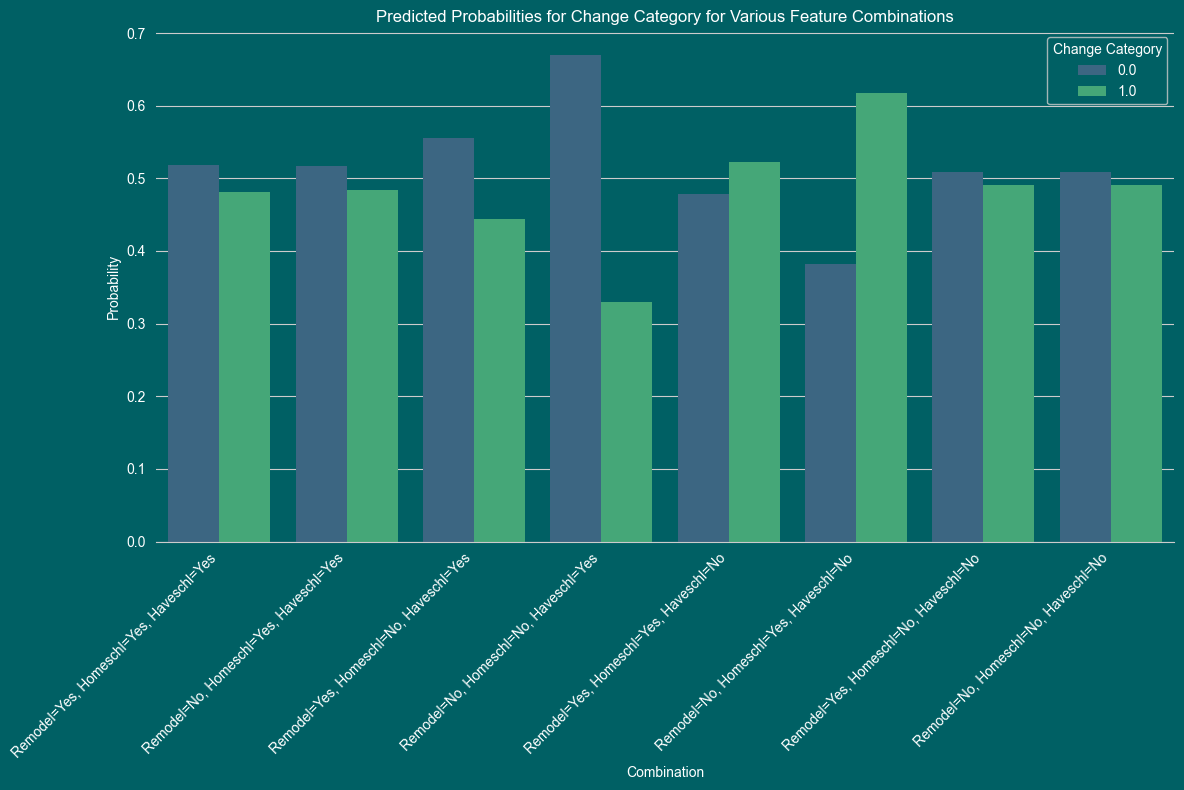

In [27]:
# Define the feature combinations to test
input_combinations = pd.DataFrame({
    'REMODEL': [1, 0, 1, 0, 1, 0, 0, 0],  # Test various combinations of 'yes' (1) and 'no' (0)
    'HOMESCHL': [1, 1, 0, 0, 1, 1, 0, 0],
    'HAVESCHL': [1, 1, 1, 1, 0, 0, 0, 0],
    # Add other features if needed; here we assume they are all zero
})

# Ensure all columns are present in the input combinations
for col in X_train.columns:
    if col not in input_combinations.columns:
        input_combinations[col] = 0

# Predict probabilities using the Random Forest model
predicted_probs = model.predict_proba(input_combinations)

# Convert predictions to a DataFrame for visualization
# The `model.classes_` should be ['decrease', 'increase', 'same'] or in a similar order
predicted_df = pd.DataFrame(predicted_probs, columns=model.classes_)
predicted_df['Combination'] = ['Remodel=Yes, Homeschl=Yes, Haveschl=Yes', 
                               'Remodel=No, Homeschl=Yes, Haveschl=Yes',
                               'Remodel=Yes, Homeschl=No, Haveschl=Yes',
                               'Remodel=No, Homeschl=No, Haveschl=Yes',
                               'Remodel=Yes, Homeschl=Yes, Haveschl=No',
                               'Remodel=No, Homeschl=Yes, Haveschl=No',
                               'Remodel=Yes, Homeschl=No, Haveschl=No',
                               'Remodel=No, Homeschl=No, Haveschl=No']

# Melt the DataFrame for easier plotting with seaborn
melted_df = pd.melt(predicted_df, id_vars='Combination', var_name='Change Category', value_name='Probability')

# Plotting the probabilities
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_df, x='Combination', y='Probability', hue='Change Category', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Probability')
plt.title('Predicted Probabilities for Change Category for Various Feature Combinations')
plt.tight_layout()
plt.legend(title='Change Category')
plt.show()

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.